Building on previous notebook:
- Qn: Does eliminating seasonality

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
from utils.fetch_data import fetch_timeseries_data
from utils.load_data import TimeSeriesDataset
from utils.early_stopping import EarlyStopping
from utils.fetch_data import create_splits

In [2]:
torch.manual_seed(1)

Get the data:

In [3]:
df = fetch_timeseries_data()

# create the training, validation, and test splits:
rail_train, rail_valid, rail_test = create_splits(df, attr='rail', train_ran=['2016-01','2024-12'],val_ran=['2025-01','2025-04'],test_ran=['2025-05'])

Seasonality exploration:

Search for weekly seasonality:
- plot out a week's worth of data and see if there's anything repeating itself

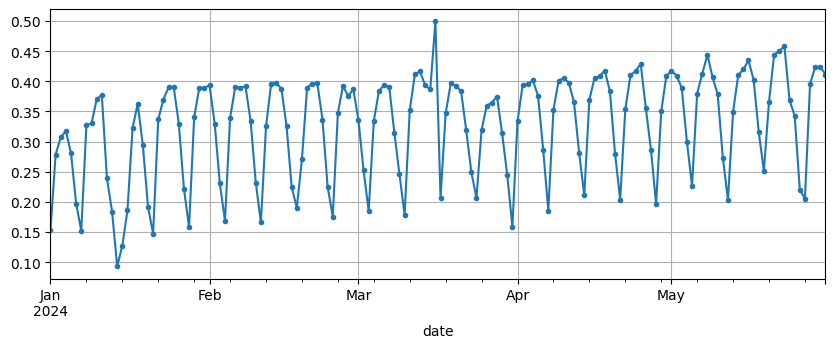

In [5]:
rail_train['2024-01':'2024-05'].plot(grid=True, marker='.', figsize=(10,3.5))
plt.show()

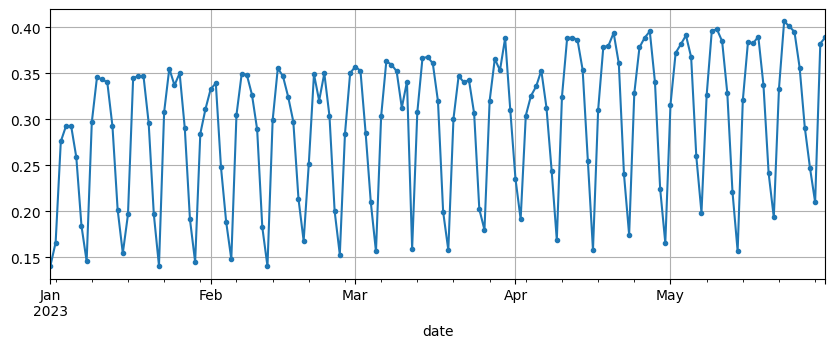

In [6]:
rail_train['2023-01':'2023-05'].plot(grid=True, marker='.', figsize=(10,3.5))
plt.show()

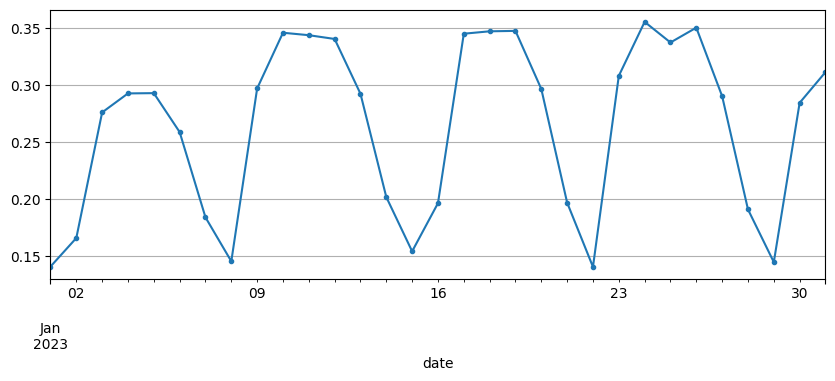

In [11]:
rail_train['2023-01'].plot(grid=True, marker='.', figsize=(10,3.5))
plt.show()

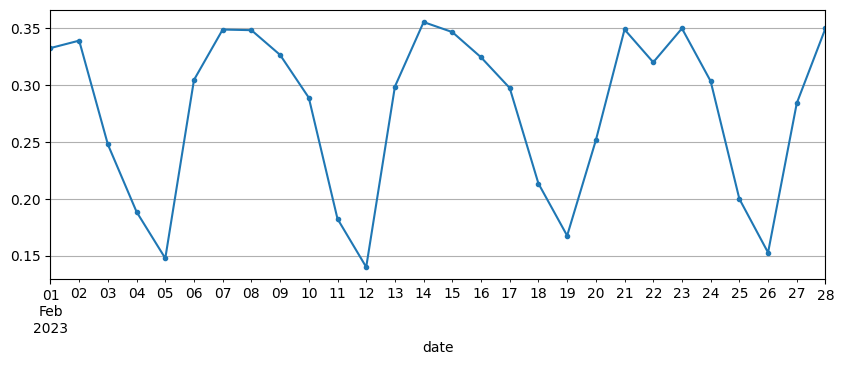

In [12]:
rail_train['2023-02'].plot(grid=True, marker='.', figsize=(10,3.5))
plt.show()

There's weekly seasonality- starts low at the start of the week, then peaks midweek before dipping again and repeating the cycle the following week. 

In [16]:
rail_train[:10]

date
2016-01-01    0.319835
2016-01-02    0.365509
2016-01-03    0.287661
2016-01-04    0.703185
2016-01-05    0.727716
2016-01-06    0.733167
2016-01-07    0.736809
2016-01-08    0.732495
2016-01-09    0.391597
2016-01-10    0.263073
Name: rail, dtype: float64

In [15]:
rail_train.diff(7)[:10]

date
2016-01-01         NaN
2016-01-02         NaN
2016-01-03         NaN
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08    0.412660
2016-01-09    0.026088
2016-01-10   -0.024588
Name: rail, dtype: float64

eliminating the weekly seasonality by subtracting today's value from last 7 days' value - should result in a flatter curve without seasonality:

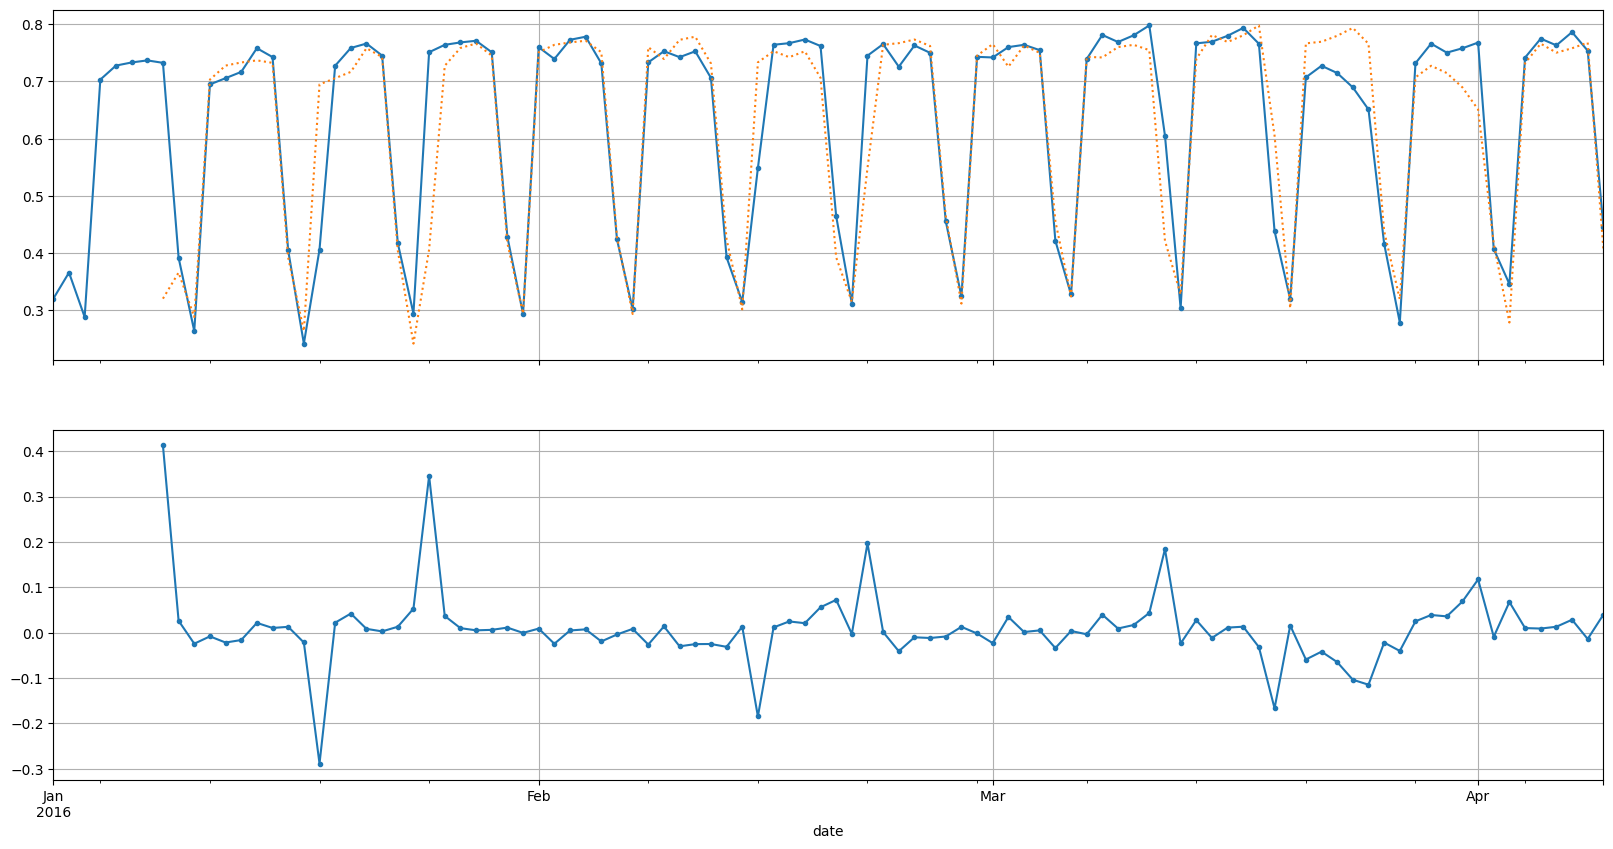

In [20]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20,10))
rail_train.iloc[:100].plot(ax=axs[0], legend=False, marker='.') # original time series
rail_train.iloc[:100].shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=':') # lagged 
rail_train.iloc[:100].diff(7).plot(ax=axs[1], grid=True, marker='.') # 7 day difference time series
plt.show()

In [21]:
# rail train values with weekly seasonality eliminated:
rail_train_se = rail_train.diff(7)

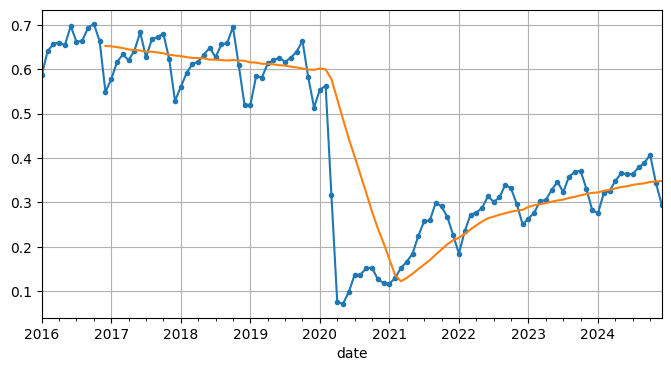

In [29]:
period = slice("2016","2024")

rt_monthly = rail_train.resample('ME').mean() # compute the mean for each month
rolling_average_12_months = rt_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))
rt_monthly[period].plot(ax=ax, marker='.')
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

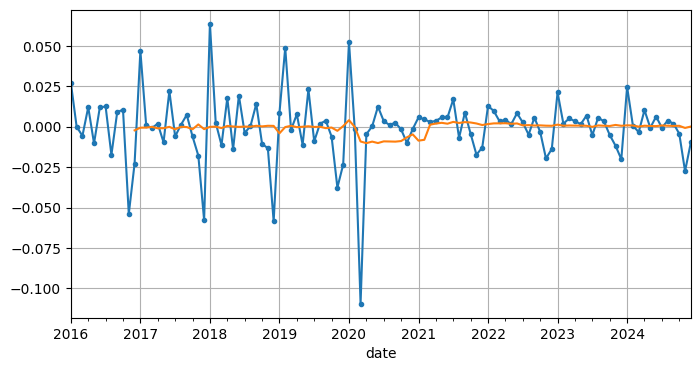

In [30]:
period = slice("2016","2024")

rt_monthly = rail_train_se.resample('ME').mean() # compute the mean for each month
rolling_average_12_months = rt_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))
rt_monthly[period].plot(ax=ax, marker='.')
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

No long term trends in the rail_train_monthly_se with weekly seasonality removed.

Using the weekly seasonality removal as a preprocessing step and applying this to both the train, validation, and test data - retraining the model and observing the changes in performance.

In [31]:
def eliminate_seasonality(data):
    data = data.diff(7)
    return data.iloc[7:]

In [39]:
def original_series(diff_data, truth):
    truth_shifted = truth.shift(7).iloc[7:]
    return truth_shifted + diff_data

Process the data

In [45]:
rail_train_p, rail_valid_p, rail_test_p = eliminate_seasonality(rail_train), eliminate_seasonality(rail_valid), eliminate_seasonality(rail_test)

Creating chunks:
- chunks for a sequence to sequence model that forecasts 14 days ahead.

In [46]:
seq_length = 56
forecasting_horizon = 14

def create_x_chunks(ds):
    return [ds[i:i+seq_length] for i in range(len(ds)-seq_length-forecasting_horizon+1)]

def create_y_chunks(ds):
    y_chunks = []
    for i in range(len(ds)-seq_length-forecasting_horizon+1):
        seq_chunk = [ds[i+j+1:i+j+1+forecasting_horizon] for j in range(seq_length)] # for each element in the sequence, get the next 14 values
        y_chunks.append(seq_chunk)
    return y_chunks

In [47]:
train_x_chunks, train_y_chunks = create_x_chunks(rail_train_p.values.tolist()), create_y_chunks(rail_train_p.values.tolist())
valid_x_chunks, valid_y_chunks = create_x_chunks(rail_valid_p.values.tolist()), create_y_chunks(rail_valid_p.values.tolist())
test_x_chunks, test_y_chunks = create_x_chunks(rail_test_p.values.tolist()), create_y_chunks(rail_test_p.values.tolist())

In [48]:
train_x_chunks, train_y_chunks = torch.tensor(train_x_chunks), torch.tensor(train_y_chunks)
valid_x_chunks, valid_y_chunks = torch.tensor(valid_x_chunks), torch.tensor(valid_y_chunks)
test_x_chunks, test_y_chunks = torch.tensor(test_x_chunks), torch.tensor(test_y_chunks)

In [49]:
train_x_chunks.shape, train_y_chunks.shape

(torch.Size([3212, 56]), torch.Size([3212, 56, 14]))

In [53]:
train_x_chunks[3211,:]

tensor([-0.0007, -0.0010, -0.0046, -0.0578, -0.0238, -0.0144, -0.0072, -0.0096,
        -0.0395, -0.0271, -0.0150,  0.0123, -0.0061, -0.0656, -0.0239,  0.0251,
         0.0145,  0.0076,  0.0045, -0.0246,  0.0588,  0.0064, -0.0111,  0.0007,
         0.0275,  0.0013,  0.0245,  0.0018, -0.0054, -0.0251,  0.0344,  0.0246,
        -0.0117, -0.0384, -0.0829, -0.1200, -0.2821, -0.2068, -0.1234, -0.0468,
         0.0045,  0.0491,  0.1021,  0.2692,  0.1469,  0.0688,  0.0411,  0.0151,
         0.0004, -0.0130, -0.0507, -0.0108, -0.0236, -0.0183, -0.0217, -0.0150])

In [54]:
train_y_chunks[3211,54,:]

tensor([-0.0150, -0.0157,  0.0229, -0.0341, -0.0284, -0.0097, -0.0748, -0.2098,
        -0.2960, -0.1485, -0.0812, -0.0115, -0.0296,  0.0177])

Logical checks above are good... lets now create the dataset that will enable batching

In [55]:
class TsDataset(Dataset):
    def __init__(self, x_chunks, y_chunks):
        super().__init__()
        self.x_chunks = x_chunks.unsqueeze(2)
        self.y_chunks = y_chunks
    def __len__(self):
        return self.x_chunks.shape[0]
    def __getitem__(self, index):
        x,y = self.x_chunks[index,:,:], self.y_chunks[index,:,:]
        return x,y

In [57]:
train_ds = TsDataset(train_x_chunks, train_y_chunks)
val_ds = TsDataset(valid_x_chunks, valid_y_chunks)
test_ds = TsDataset(test_x_chunks, test_y_chunks)

In [64]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128)
test_dl = DataLoader(test_ds, batch_size=1024)

Model building:
- Using the same simple LSTM as last time

In [65]:
torch.manual_seed(1)

In [66]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super().__init__()
        self.input = nn.Linear(input_size, 4*hidden_size,device=device) # instead of breaking this down, could just compute these with one linear layer and break down its results later
        nn.init.xavier_uniform_(self.input.weight.data)
        self.hidden = nn.Linear(hidden_size, 4*hidden_size,device=device) # same for this
        nn.init.xavier_uniform_(self.hidden.weight.data)
        nn.init.zeros_(self.input.bias)
        nn.init.zeros_(self.hidden.bias)

        self.hidden_size = hidden_size
        self.ln_gates = nn.LayerNorm(4*hidden_size,device=device)
        self.ln_c = nn.LayerNorm(hidden_size, device=device)
        self.device = device
    def forward(self, x, prev_h, prev_c):
        computed_inputs = self.input(x)
        computed_hiddens = self.hidden(prev_h)

        gates = self.ln_gates(computed_inputs+computed_hiddens)

        # compute the input gate
        input_gate = torch.sigmoid(gates[:,:self.hidden_size])
        forget_gate = torch.sigmoid(gates[:,self.hidden_size:2*self.hidden_size])
        signal = torch.tanh(gates[:,2*self.hidden_size:3*self.hidden_size])
        output_gate = torch.sigmoid(gates[:,3*self.hidden_size:4*self.hidden_size])
        long_state = forget_gate*prev_c + input_gate*signal
        return output_gate*torch.tanh(self.ln_c(long_state)), long_state

In [67]:
class CustomLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super().__init__()
        self.lstm_cell = CustomLSTMCell(input_size, hidden_size,device)
        self.hidden_size = hidden_size
        self.device = device
    def forward(self, input):
        batch, seq_len, _ = input.shape
        short_term_state = []
        long_term_state = []
        prev_h = torch.zeros((batch, self.hidden_size), device=self.device)
        prev_c = torch.zeros((batch, self.hidden_size), device= self.device)

        for i in range(seq_len):
            xt = input[:,i,:]
            prev_h, prev_c = self.lstm_cell(xt, prev_h, prev_c)
            short_term_state.append(prev_h)
            long_term_state.append(prev_c)
        out = torch.stack(short_term_state, dim=1)
        return out, (prev_h,  prev_c) 

In [163]:
torch.manual_seed(1)

In [164]:
class Seq2SeqUnivar(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, device):
        super().__init__()
        #self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=1)
        self.lstm = CustomLSTMLayer(input_size, hidden_size1,device)
        self.lstm2 = CustomLSTMLayer(hidden_size1, hidden_size2,device)
        #nn.init.xavier_uniform_(self.lstm.weight_ih_l0.data)
        #nn.init.xavier_uniform_(self.lstm.weight_hh_l0.data)
        self.linear = nn.Linear(hidden_size2, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64,32)
        self.linear3 = nn.Linear(32,14)
        self.ln = nn.LayerNorm(128)
        self.ln2 = nn.LayerNorm(64)
        self.ln3 = nn.LayerNorm(32)
        self.ln
    def forward(self, input):
        out, (_,_) = self.lstm(input)
        out, (_,_) = self.lstm2(out)
        out = self.ln(out)
        out = self.relu(self.ln2(self.linear(out)))
        out = self.relu(self.ln3(self.linear2(out)))
        return self.linear3(out)

In [165]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [166]:
model = Seq2SeqUnivar(1, 512, 128, device=device).to(device)

In [167]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.HuberLoss(reduction='sum')
early_stopper = EarlyStopping(patience=50, checkpoint_path='seq2seqx.pt', restore_best_weights=True, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=10, factor=0.9)

In [168]:
n_epochs = 1000

train_loss = [0] * n_epochs
val_loss = [0] * n_epochs

for epoch in range(n_epochs):
    model.train()
    # iterate through the training data
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(x_batch)
        # adding l1 norm
        norm = sum(p.abs().sum() for p in model.parameters())
        loss = criterion(out, y_batch) + 1e-3*norm
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        train_loss[epoch]+=loss.item()
    train_loss[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
        for x_batch,y_batch in val_dl:
            x_batch,y_batch = x_batch.to(device),y_batch.to(device)
            out = model(x_batch)
            loss = criterion(out, y_batch)
            val_loss[epoch] += loss.item()
        val_loss[epoch] /= len(val_dl.dataset)

        scheduler.step(val_loss[epoch])
        print(f'Epoch: {epoch+1}| Train loss: {train_loss[epoch]:.4f}| Val loss: {val_loss[epoch]:.4f}')
        early_stopper(val_loss[epoch], model, optimizer, epoch)
        if early_stopper.should_stop:
            print(f"Stopping at epoch: {epoch+1}")
            break

Epoch: 1| Train loss: 13.1026| Val loss: 1.8754
Metric improved to 1.8754. Checkpoint saved at epoch 0
Epoch: 2| Train loss: 2.9678| Val loss: 1.7878
Metric improved to 1.7878. Checkpoint saved at epoch 1
Epoch: 3| Train loss: 2.9305| Val loss: 1.7730
Metric improved to 1.7730. Checkpoint saved at epoch 2
Epoch: 4| Train loss: 2.9257| Val loss: 1.7780
No improvement for 1 epoch(s)
Epoch: 5| Train loss: 2.9248| Val loss: 1.7774
No improvement for 2 epoch(s)
Epoch: 6| Train loss: 2.9238| Val loss: 1.7694
Metric improved to 1.7694. Checkpoint saved at epoch 5
Epoch: 7| Train loss: 2.9230| Val loss: 1.7694
Metric improved to 1.7694. Checkpoint saved at epoch 6
Epoch: 8| Train loss: 2.9224| Val loss: 1.7717
No improvement for 1 epoch(s)
Epoch: 9| Train loss: 2.9220| Val loss: 1.7752
No improvement for 2 epoch(s)
Epoch: 10| Train loss: 2.9217| Val loss: 1.7776
No improvement for 3 epoch(s)
Epoch: 11| Train loss: 2.9215| Val loss: 1.7723
No improvement for 4 epoch(s)
Epoch: 12| Train loss: 2.

In [169]:
l1_loss = nn.L1Loss(reduction='mean')
loss_ = []

with torch.no_grad():
    model.eval()
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        out = model(x_batch)
        loss = l1_loss(out, y_batch)
        loss_.append(loss.item())
        break

In [170]:
(sum(loss_)/len(loss_)) * 1e6

35053.84549498558

In [171]:
pred_set = torch.tensor(rail_test_p.iloc[:56].values.tolist(), device=device).reshape(1,56,1)

In [172]:
with torch.no_grad():
    model.eval()
    prediction = model(pred_set)

In [173]:
def original_series(diff_data, truth):
    truth_shifted = truth.shift(7).iloc[7:]
    return truth_shifted + diff_data

In [174]:
pred_set_truth = rail_test.diff(7)[7:].iloc[:56] + rail_test.shift(7)[7:].iloc[:56]

In [175]:
prediction_processed = pd.Series(
    prediction[-1,-1,:].detach().cpu().numpy(),
    index = rail_test_p.iloc[56:56+14].index
) + rail_test.shift(7).iloc[7:].iloc[56:56+14]

In [176]:
prediction_processed

date
2025-07-03    0.469967
2025-07-04    0.420435
2025-07-05    0.350470
2025-07-06    0.313704
2025-07-07    0.370252
2025-07-08    0.461006
2025-07-09    0.447348
2025-07-10    0.440137
2025-07-11    0.292115
2025-07-12    0.342134
2025-07-13    0.281724
2025-07-14    0.411405
2025-07-15    0.453052
2025-07-16    0.460160
dtype: float64

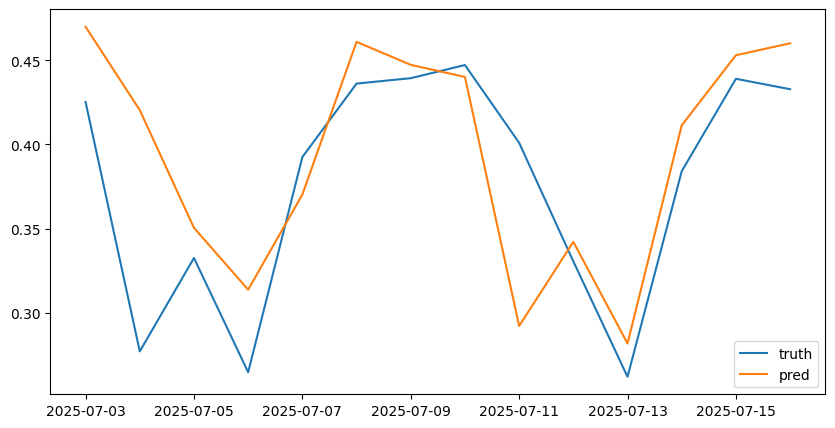

In [177]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot((rail_test_p.iloc[56:56+14] + rail_test.shift(7).iloc[7:].iloc[56:56+14]),label='truth')
ax.plot(prediction_processed,label='pred'
)
ax.legend()

eliminating the seasonality doesn't result in a huge performance improvement